# 41_group DST-27
### Khokhlov Timofey

# **Импортируем библиотеки**

In [1]:
import warnings
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score


import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore")  # Убирает некритические сообщения

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Зафиксируем random_seed
RANDOM_SEED = 42
!pip freeze > requirements.txt

# **Загружаем датасет**

In [3]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

# **Смотрим информацию о датасетах**

Описания полей датасета

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [5]:
train.head(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
5,41415,18FEB2014,SCH,M,27,Y,N,0,1,-2.032257,0,50,1,1,15000,2,3,N,0
6,28436,04FEB2014,SCH,M,39,N,N,0,0,-2.225004,0,60,1,2,28000,1,1,N,0
7,68769,17MAR2014,SCH,F,39,N,N,0,0,-1.522739,1,50,2,3,45000,3,3,N,0
8,38424,14FEB2014,SCH,F,50,Y,N,1,0,-1.676061,0,50,1,1,30000,1,4,N,0
9,4496,10JAN2014,UGR,F,54,N,N,0,0,-2.695176,1,50,2,3,24000,1,3,N,0


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [7]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


### **Посмотрим на пропуски в датасетах**

In [8]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

Пропуски есть только в столбцах education. Посмотрим значение этого призна в обоих датасетах

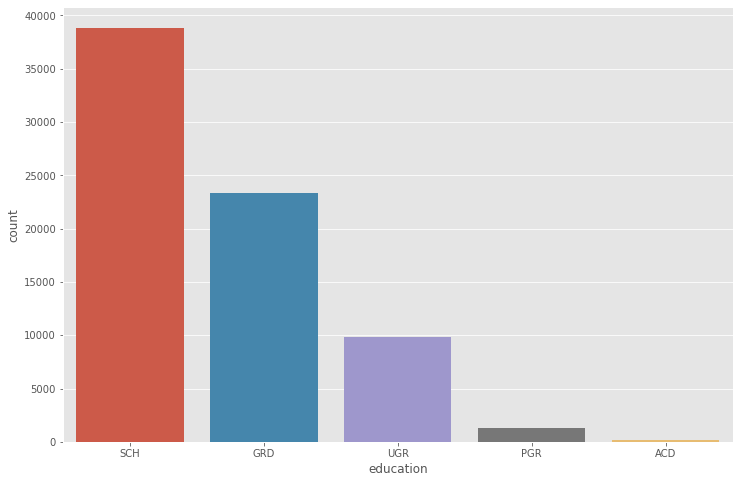

In [9]:
sns.countplot(train['education'])

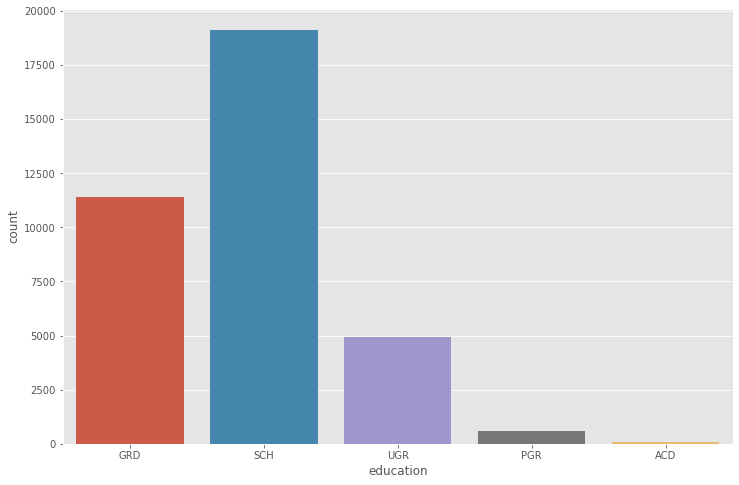

In [10]:
sns.countplot(test['education'])

Видим, что в обеих датасетах в столбце education чаще всего встречается значение "SCH". Заполним пропуски этим значением

In [11]:
train['education'].fillna(train.education.value_counts().index[0], inplace=True)
train.isnull().sum() #Убедимся, что пропусков не осталось

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
dtype: int64

In [12]:
test['education'].fillna(test.education.value_counts().index[0], inplace=True)
test.isnull().sum() #Убедимся, что пропусков не осталось

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
dtype: int64

# **Работа с признаками и feature engineering**

In [13]:
# Взглянем поближе на признак app_date
train.app_date.head(5), test.app_date.head(5)

(0    01FEB2014
 1    12MAR2014
 2    01FEB2014
 3    23JAN2014
 4    18APR2014
 Name: app_date, dtype: object,
 0    22MAR2014
 1    24JAN2014
 2    23MAR2014
 3    03FEB2014
 4    04FEB2014
 Name: app_date, dtype: object)

#### **Сконвертируем значение признака в удобный формат datetime**

In [14]:
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)
print(train.app_date.head(5))
print(test.app_date.head(5))

0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]
0   2014-03-22
1   2014-01-24
2   2014-03-23
3   2014-02-03
4   2014-02-04
Name: app_date, dtype: datetime64[ns]


#### **На основе признака app_date создадим новый признак**

In [15]:
current_date = pd.to_datetime('20JAN2021')
# Количество дней, прошедших со дня подачи заявки
train['days_passed'] = (current_date - train.app_date).dt.days
test['days_passed'] = (current_date - test.app_date).dt.days

In [16]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days_passed
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,2545
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,2506
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,2545
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,2554
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,2469


In [17]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days_passed
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,2496
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,2553
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,2495
3,26883,2014-02-03,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,2543
4,28862,2014-02-04,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,2542


#### **Разделим колонки по типам данным для большего удобства работы и изучения**

In [18]:
# Бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# Категориальные признаки
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']

# Числовые признаки
num_cols = ['days_passed', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'region_rating']

# **Визуализация и преобразование данных**

### **Посмотрим на распределение целевой переменной**

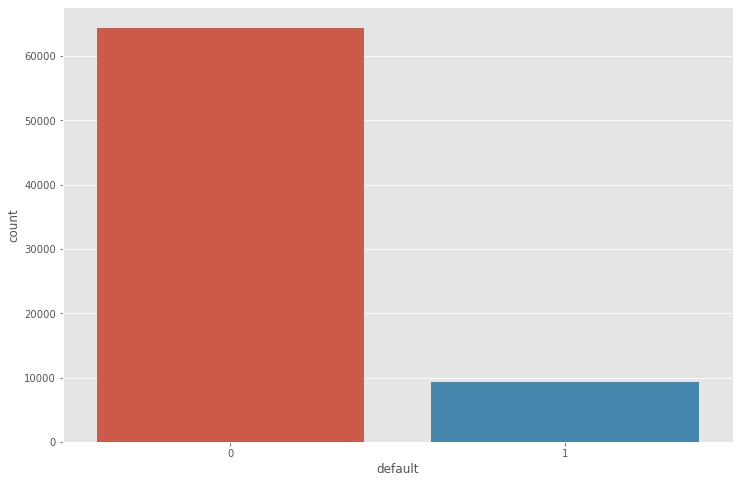

In [19]:
sns.countplot(train['default'])

In [20]:
train['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

**Видим, что распределение не равномерное и дефолтных заемщиков сильно меньше. А значит, у нас неравномерное распределение классов. Для устранения дисбаланса применим oversamping.**

In [21]:
train_0 = train[train['default'] == 0]
train_1 = train[train['default'] == 1]
koeff = int(len(train_0)/len(train_1)) # вычислим, во сколько раз недефолтных заемщиков больше, чем дефолтных

# Добавим в обучающую выборку скопированные записи дефолтных заемщиков столько раз, чтобы количество дефолтных и недефолтных
# заемщиков в выборке стало примерно одинаковым
for i in range(koeff):
    train = train.append(train_1).reset_index(drop=True)

train['default'].value_counts()

1    65604
0    64427
Name: default, dtype: int64

### **Посмотрим на распределния числовых признаков**

In [22]:
print(num_cols)

['days_passed', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'region_rating']


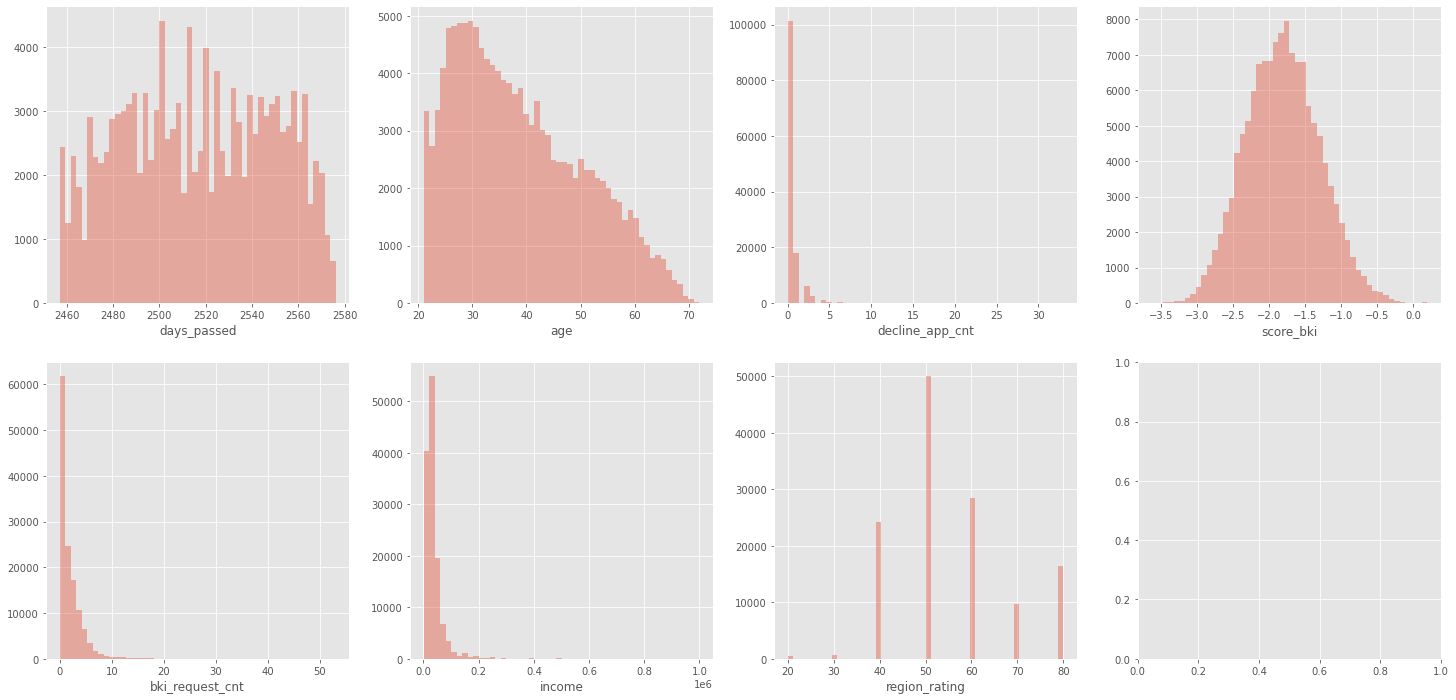

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

**Видим, что распределение некоторых признаков смещено. Попробуем скорректировать значения этих признаков**

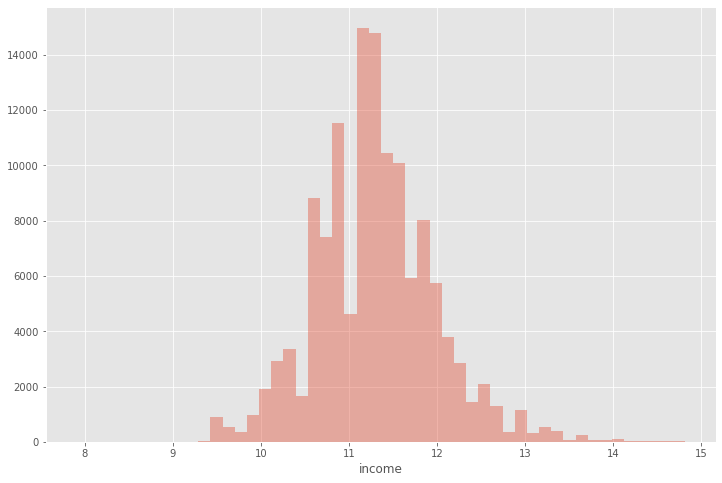

In [24]:
# Прологорифмируем значение признака income

train['income'] = train['income'].apply(lambda x: np.log(x) + 1)
sns.distplot(train['income'], kde=False, rug=False)

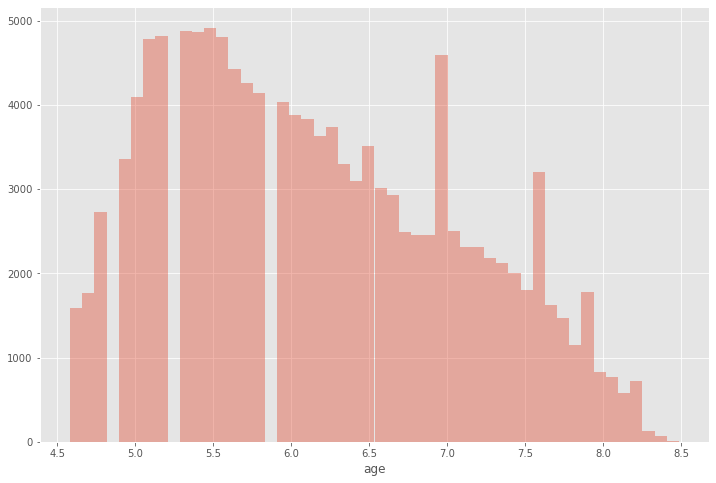

In [25]:
# Возьмем квадратный корень из значения признака age

train['age'] = train['age'].apply(lambda x: np.sqrt(x))
sns.distplot(train['age'], kde=False, rug=False)

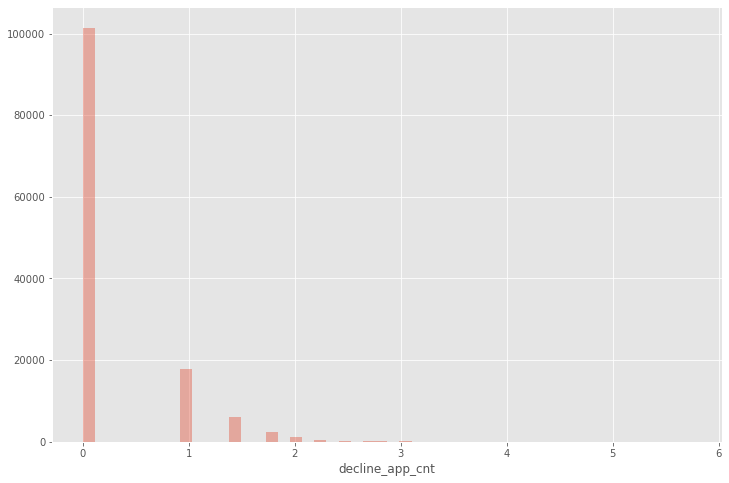

In [26]:
# Возьмем квадратный корень из значения признака decline_app_cnt

train['decline_app_cnt'] = train['decline_app_cnt'].apply(lambda x: np.sqrt(x))
sns.distplot(train['decline_app_cnt'], kde=False, rug=False)

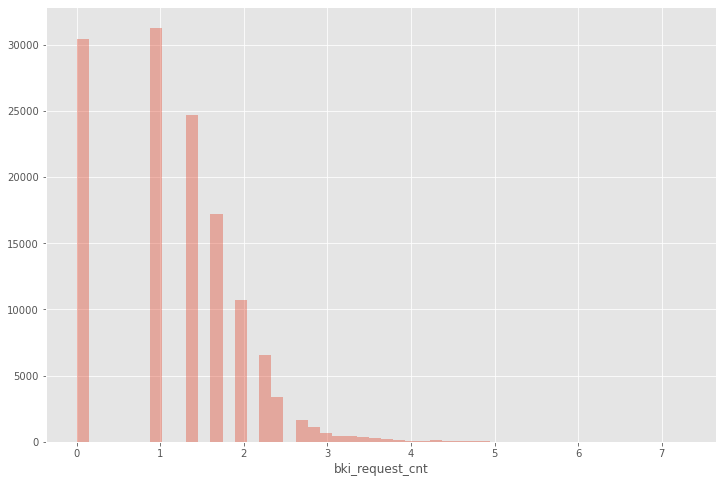

In [27]:
# Возьмем квадратный корень из значения признака decline_app_cnt

train['bki_request_cnt'] = train['bki_request_cnt'].apply(lambda x: np.sqrt(x))
sns.distplot(train['bki_request_cnt'], kde=False, rug=False)

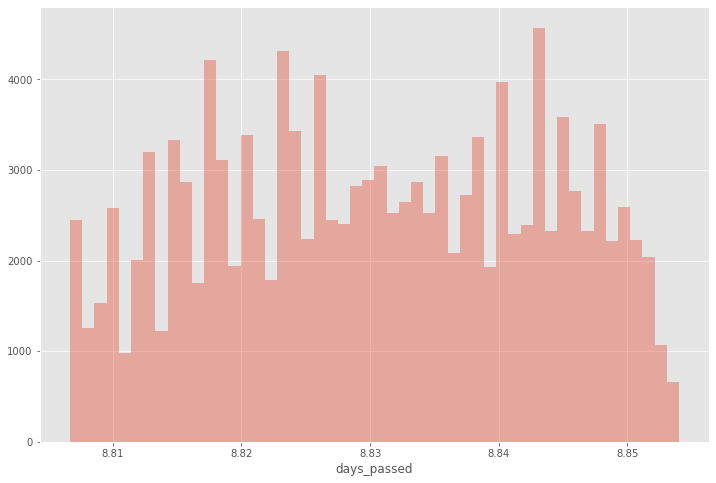

In [28]:
# Прологорифмируем значение признака days_passed

train['days_passed'] = train['days_passed'].apply(lambda x: np.log(x) + 1)
sns.distplot(train['days_passed'], kde=False, rug=False)

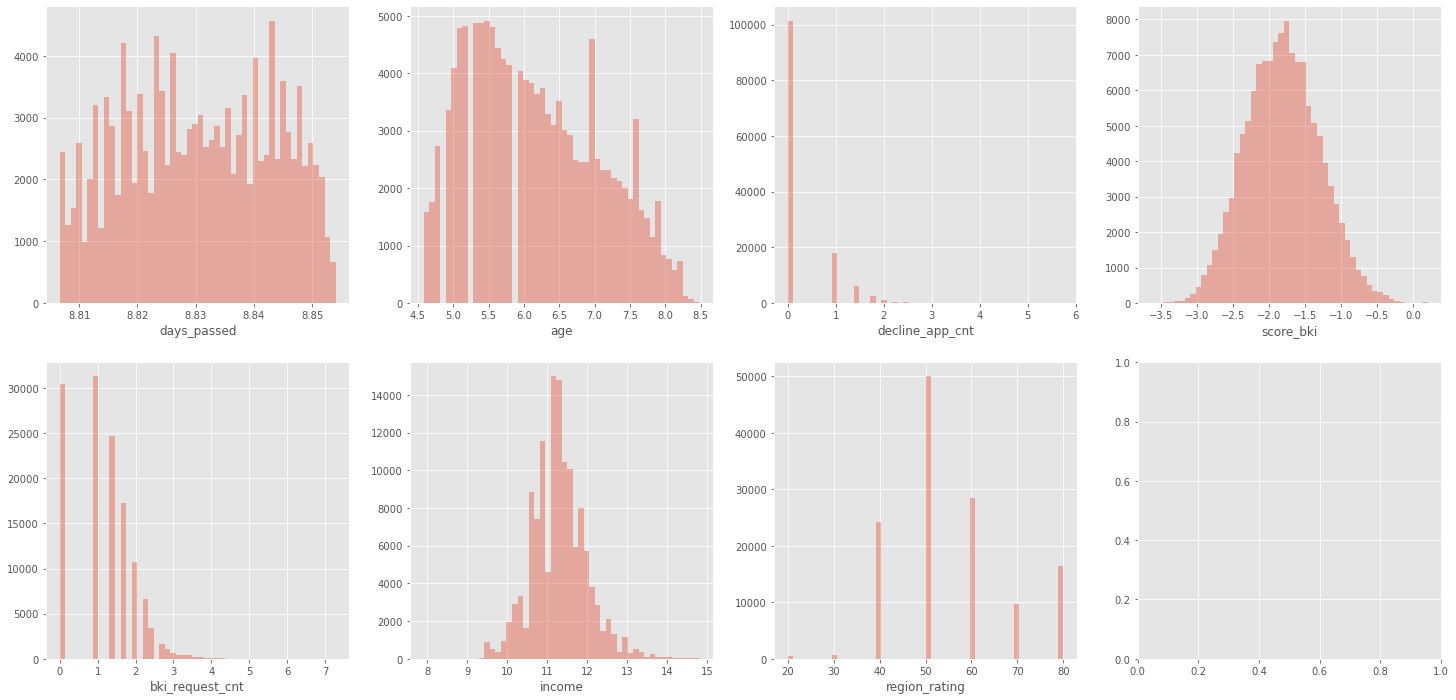

In [29]:
# Посмотрим на получившиеся распределения тренировочного датасета

fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

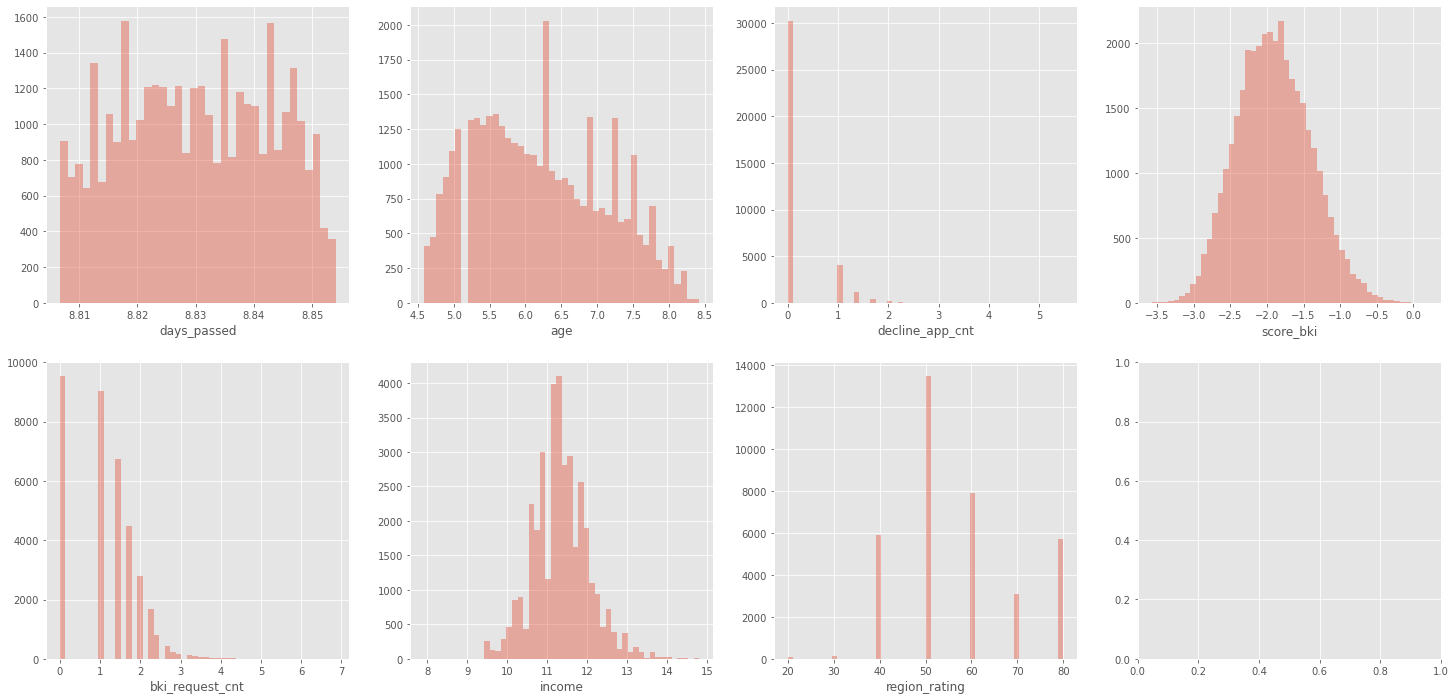

In [30]:
# Проделаем аналогичные операции для тестовой выборки

test['days_passed'] = test['days_passed'].apply(lambda x: np.log(x) + 1)
test['income'] = test['income'].apply(lambda x: np.log(x) + 1)
test['age'] = test['age'].apply(lambda x: np.sqrt(x))
test['decline_app_cnt'] = test['decline_app_cnt'].apply(lambda x: np.sqrt(x))
test['bki_request_cnt'] = test['bki_request_cnt'].apply(lambda x: np.sqrt(x))

fig, axes = plt.subplots(2, 4, figsize=(25, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(test[col], kde=False, ax=axes.flat[i])

### **Посмотрим на матрицу корреляций числовых признаков**

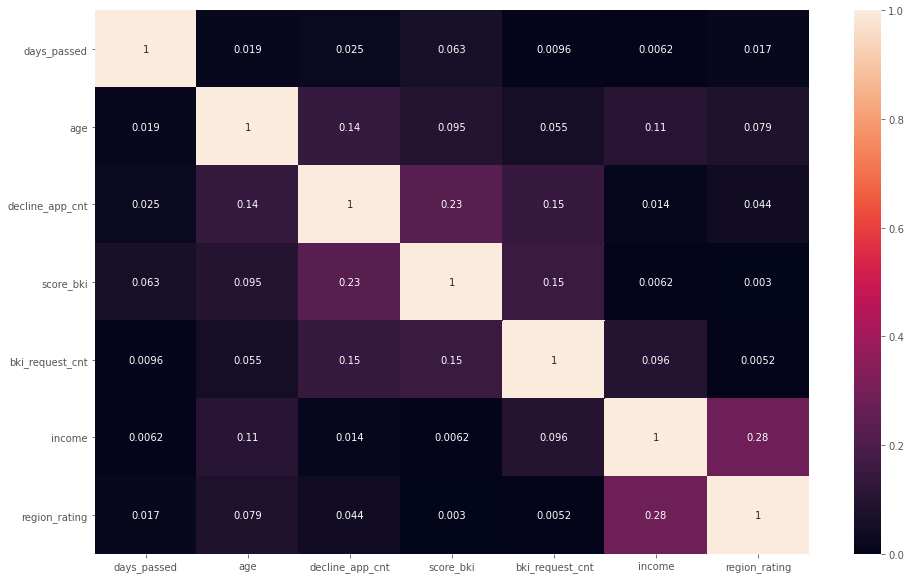

In [31]:
plt.figure(figsize=(16,10))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

**Корреляции между признаками достаточно мала**

In [32]:
#train['income_region_rating'] = train['region_rating'] ** (1/(train['income'] / train['age']))
#sns.distplot(train['income_region_rating'], kde=False, rug=False)

In [33]:
# Числовые признаки
#new_num_cols = ['days_passed', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt'
#            , 'income', 'region_rating', 'income_region_rating'
#           ]

#plt.figure(figsize=(16,10))
#sns.heatmap(train[new_num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

### **Посмотрим на выбросы в числовых признаках**

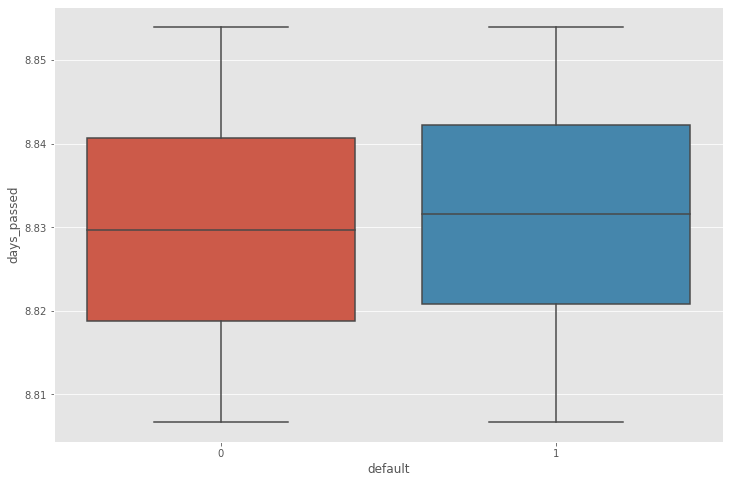

In [34]:
sns.boxplot(x=train.default, y=train.days_passed)

**У признака days_passed выбросов нет. Дефолтные клиенты, в среднем, оформляли заявки раньше, чем недефолтные**

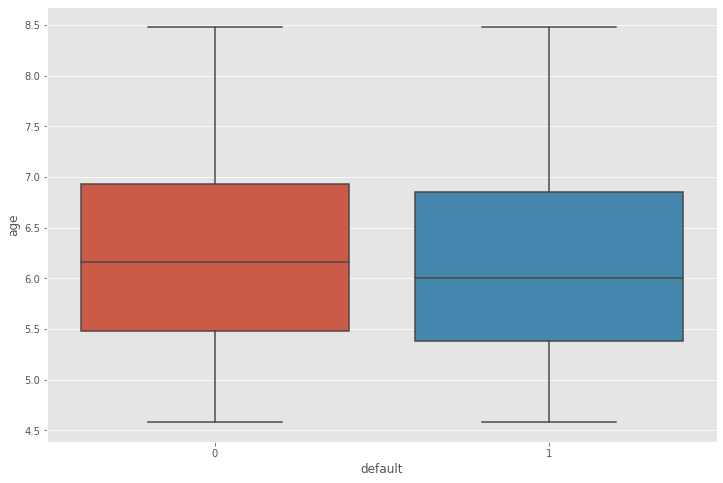

In [35]:
sns.boxplot(x=train.default, y=train.age)

**У признака age выбросов нет. Недефолтные клиенты, в среднем, старше дефолтных**

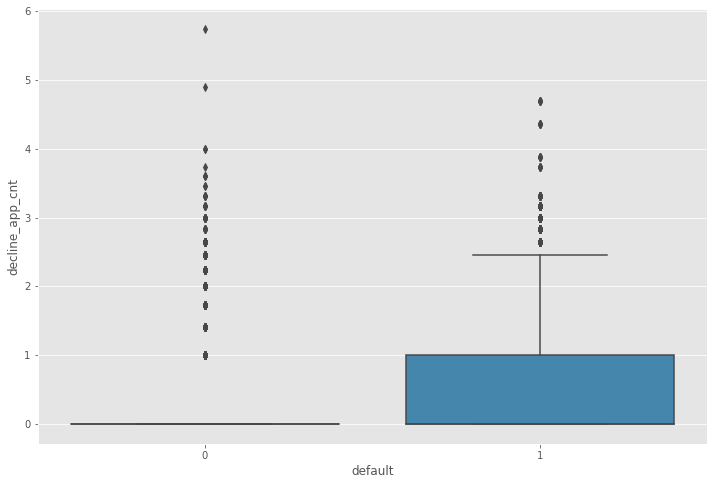

In [36]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

**У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных. Есть выбросы, но удалять их не стоит, так как медиана значений признака decline_app_cnt находится около 0, и при удалении выбросов признак "схлопнется" в 0**

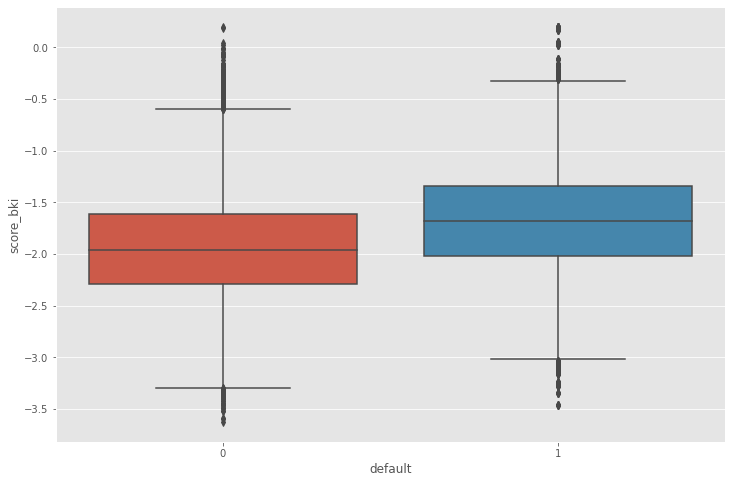

In [37]:
sns.boxplot(x=train.default, y=train.score_bki)

**Скоринговый балл у дефолтных заемщиков, в среднем, выше, чем у недефолтных, что довольно странно. Вероятно, логика этого признака такая, что чем ниже балл - тем надежнее заемщик. Есть выбросы, их можно убрать**

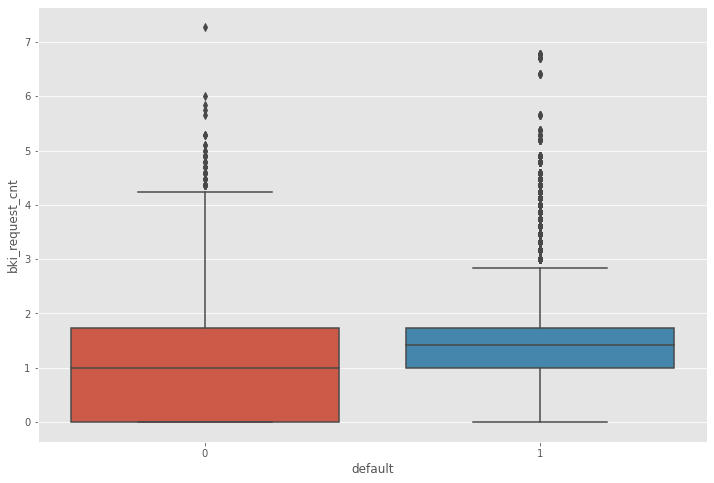

In [38]:
sns.boxplot(x=train.default, y=train.bki_request_cnt)

**У дефолтных заемщиков количество запросов в БКИ, в среднем, выше, чем у недефолтных. Есть выбросы, можно убрать**

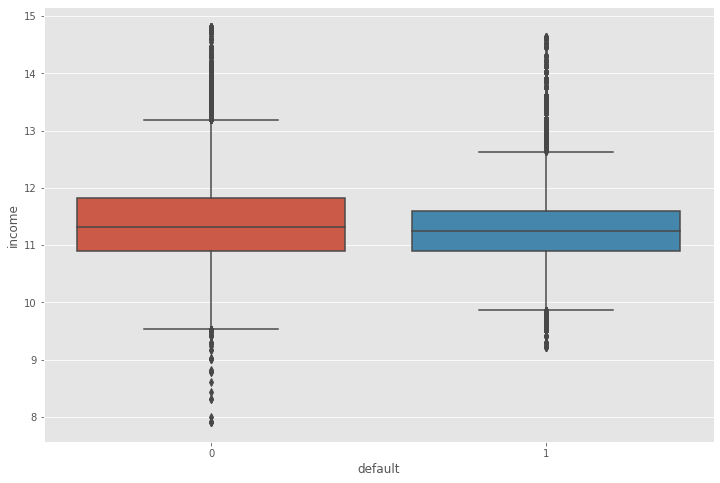

In [39]:
sns.boxplot(x=train.default, y=train.income)

**У недефолтных заемщиков доход, в среднем, чуть выше, чем у дефолтных. Есть выбросы, можно убрать**

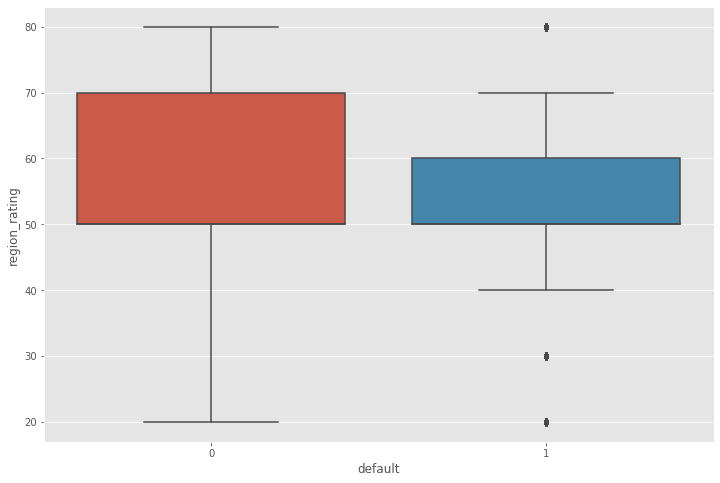

In [40]:
sns.boxplot(x=train.default, y=train.region_rating)

**Среднее значение признака region_rating больше у недефолтных клиентов. Есть пару выбросов, их можно проигнорировать**

### **Избавимся от выбросов**

In [41]:
# Функция определяет межквартильный интервал и возвращает 1.5 межквартильных расстояния с обеих сторон от интервала

def outliers_iqr(series):
    quartile_1, quartile_3 = np.percentile(series, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130031 entries, 0 to 130030
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         130031 non-null  int64         
 1   app_date          130031 non-null  datetime64[ns]
 2   education         130031 non-null  object        
 3   sex               130031 non-null  object        
 4   age               130031 non-null  float64       
 5   car               130031 non-null  object        
 6   car_type          130031 non-null  object        
 7   decline_app_cnt   130031 non-null  float64       
 8   good_work         130031 non-null  int64         
 9   score_bki         130031 non-null  float64       
 10  bki_request_cnt   130031 non-null  float64       
 11  region_rating     130031 non-null  int64         
 12  home_address      130031 non-null  int64         
 13  work_address      130031 non-null  int64         
 14  inco

In [43]:
# Убираем выбросы в численных столбцах
outliers_num_cols = ['score_bki', 'bki_request_cnt', 'income']
for colname in outliers_num_cols:
    border = outliers_iqr(train[colname])
    train = train.loc[train[colname].between(border[0], border[1])]

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123529 entries, 0 to 130030
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         123529 non-null  int64         
 1   app_date          123529 non-null  datetime64[ns]
 2   education         123529 non-null  object        
 3   sex               123529 non-null  object        
 4   age               123529 non-null  float64       
 5   car               123529 non-null  object        
 6   car_type          123529 non-null  object        
 7   decline_app_cnt   123529 non-null  float64       
 8   good_work         123529 non-null  int64         
 9   score_bki         123529 non-null  float64       
 10  bki_request_cnt   123529 non-null  float64       
 11  region_rating     123529 non-null  int64         
 12  home_address      123529 non-null  int64         
 13  work_address      123529 non-null  int64         
 14  inco

In [44]:
# Проверим, что количество дефолтных и недефолтных клиентов осталось тем же
train['default'].value_counts()

1    61971
0    61558
Name: default, dtype: int64

### **Преобразование бинарных и категориальных признаков**

In [45]:
print(bin_cols)

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']


#### **Преобразуем бинарные переменные при помощи класса LabelEncoder**

In [46]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])


# убедимся в преобразовании
display(train.head())
display(test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days_passed
0,25905,2014-02-01,SCH,1,7.874008,1,1,0.000000,0,-2.008753,1.000000,50,1,2,10.798127,4,1,0,0,8.841886
1,63161,2014-03-12,SCH,0,7.681146,0,0,0.000000,0,-1.532276,1.732051,50,2,3,10.852194,4,1,0,0,8.826443
2,25887,2014-02-01,SCH,1,5.000000,1,0,1.414214,0,-1.408142,1.000000,80,1,2,11.308953,1,4,1,0,8.841886
3,16222,2014-01-23,SCH,0,7.280110,0,0,0.000000,0,-2.057471,1.414214,50,2,3,10.210340,1,3,0,0,8.845416
4,101655,2014-04-18,GRD,1,6.928203,0,0,0.000000,1,-1.244723,1.000000,60,2,3,11.308953,1,4,1,0,8.811568


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days_passed
0,74835,2014-03-22,GRD,1,5.385165,1,1,0.000000,0,-2.271884,1.732051,50,1,2,11.819778,1,4,0,8.822445
1,17527,2014-01-24,SCH,0,6.244998,0,0,2.236068,0,-1.504999,1.414214,50,1,2,9.517193,4,3,0,8.845024
2,75683,2014-03-23,UGR,1,7.071068,1,1,0.000000,0,-1.691339,1.000000,50,1,2,11.308953,1,3,1,8.822044
3,26883,2014-02-03,SCH,1,7.483315,0,0,0.000000,0,-2.374182,1.000000,40,1,2,10.740969,1,3,0,8.841100
4,28862,2014-02-04,GRD,0,6.164414,0,0,0.000000,0,-2.487502,0.000000,80,2,3,12.695247,1,3,0,8.840706


In [47]:
print(cat_cols)

['education', 'home_address', 'work_address', 'sna', 'first_time']


#### **Разложим признак education на dummy-признаки**

In [48]:
train = pd.get_dummies(train, columns=['education'])
test = pd.get_dummies(test, columns=['education'])

# убедимся в преобразовании
display(train.head())
display(test.head())

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days_passed,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
0,25905,2014-02-01,1,7.874008,1,1,0.000000,0,-2.008753,1.000000,50,1,2,10.798127,4,1,0,0,8.841886,0,0,0,1,0
1,63161,2014-03-12,0,7.681146,0,0,0.000000,0,-1.532276,1.732051,50,2,3,10.852194,4,1,0,0,8.826443,0,0,0,1,0
2,25887,2014-02-01,1,5.000000,1,0,1.414214,0,-1.408142,1.000000,80,1,2,11.308953,1,4,1,0,8.841886,0,0,0,1,0
3,16222,2014-01-23,0,7.280110,0,0,0.000000,0,-2.057471,1.414214,50,2,3,10.210340,1,3,0,0,8.845416,0,0,0,1,0
4,101655,2014-04-18,1,6.928203,0,0,0.000000,1,-1.244723,1.000000,60,2,3,11.308953,1,4,1,0,8.811568,0,1,0,0,0


,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days_passed,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
0,74835,2014-03-22,1,5.385165,1,1,0.000000,0,-2.271884,1.732051,50,1,2,11.819778,1,4,0,8.822445,0,1,0,0,0
1,17527,2014-01-24,0,6.244998,0,0,2.236068,0,-1.504999,1.414214,50,1,2,9.517193,4,3,0,8.845024,0,0,0,1,0
2,75683,2014-03-23,1,7.071068,1,1,0.000000,0,-1.691339,1.000000,50,1,2,11.308953,1,3,1,8.822044,0,0,0,0,1
3,26883,2014-02-03,1,7.483315,0,0,0.000000,0,-2.374182,1.000000,40,1,2,10.740969,1,3,0,8.841100,0,0,0,1,0
4,28862,2014-02-04,0,6.164414,0,0,0.000000,0,-2.487502,0.000000,80,2,3,12.695247,1,3,0,8.840706,0,1,0,0,0


#### **Преобразуем категориальные переменные при помощи OneHotEncoder**

In [49]:
cat_cols = ['home_address', 'work_address', 'sna', 'first_time',
            'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR'
           ]

X_cat_train = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
X_cat_test = OneHotEncoder(sparse=False).fit_transform(test[cat_cols].values)

print(X_cat_train.shape)
print(X_cat_test.shape)

(123529, 24)
(36349, 24)


# **Проверяем значимость признаков**

### **Значимость числовых признаков**

Text(0.5, 0, 'F-value')

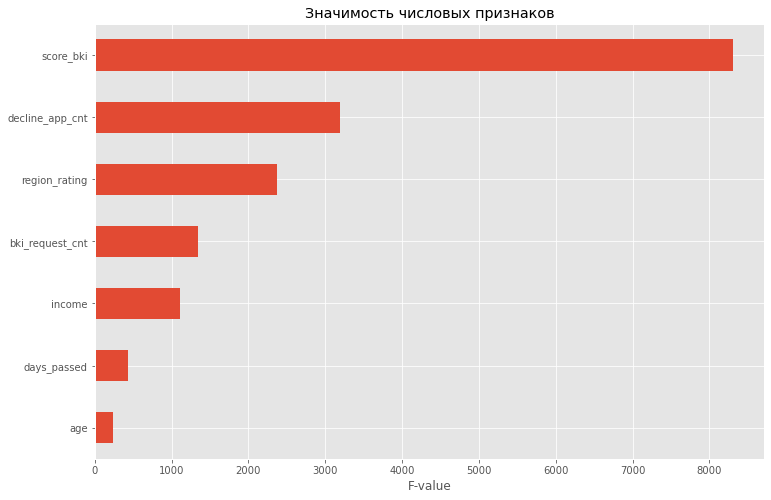

In [50]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Значимость числовых признаков')
plt.xlabel('F-value')

### **Значимость бинарных признаков**

Text(0.5, 1.0, 'Значимость бинарных признаков')

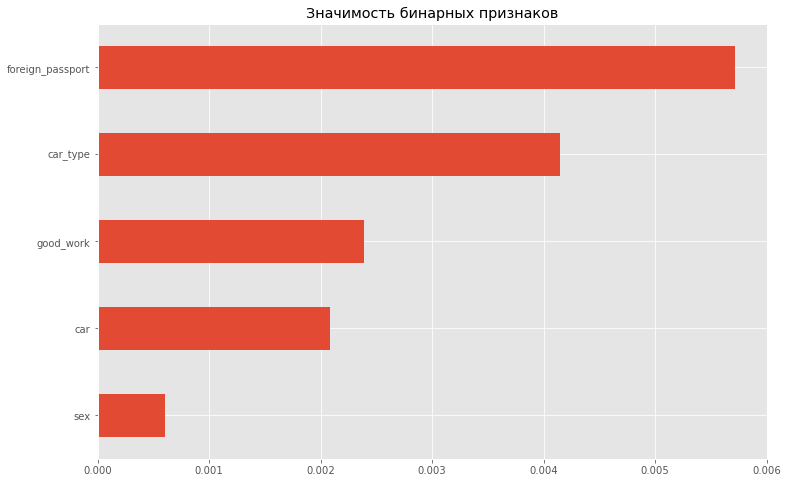

In [51]:
imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'], discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Значимость бинарных признаков')

### **Значимость категориальных признаков**

Text(0.5, 1.0, 'Значимость категориальных признаков')

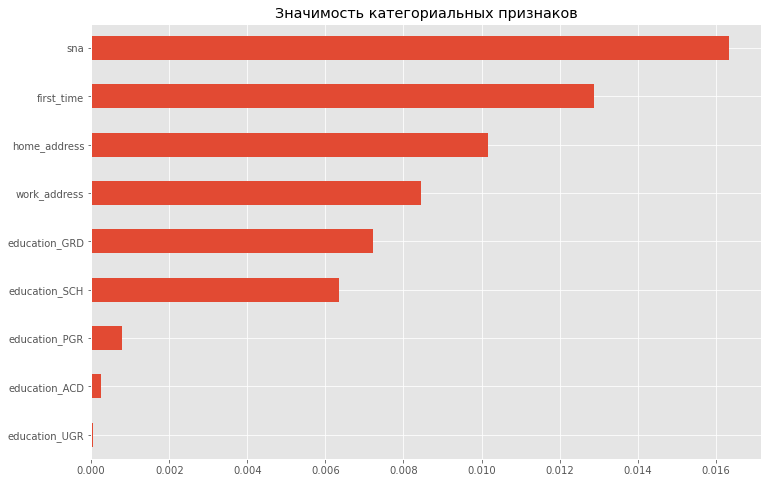

In [52]:
imp_cat = pd.Series(mutual_info_classif(train[cat_cols], train['default'],
                                        discrete_features=True), 
                                        index=train[cat_cols].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Значимость категориальных признаков')

**Исходя из данных графиков можно сделать вывод о малозначимости признака sex и age. А также мы можем увидеть значимость различных степеней образования на наш результат (наибольший вклад приносит признак education_GRD, а наименьший - education_UGR)**

# **Подготовка данных к машинному обучению**

In [53]:
poly = PolynomialFeatures(2)

x_p_train = poly.fit_transform(train[num_cols].values)
x_p_test = poly.fit_transform(test[num_cols].values)

In [54]:
# Стандартизуем числовые переменные

X_num_train = StandardScaler().fit_transform(x_p_train)
print(X_num_train.shape)
print(X_num_train)

(123529, 36)
[[ 0.          0.90869366  1.87328569 ... -0.79796579 -0.54096991
  -0.47506091]
 [ 0.         -0.31052886  1.6618797  ... -0.71223888 -0.52381765
  -0.47506091]
 [ 0.          0.90869366 -1.27706049 ...  0.02906722  1.77367234
   2.13263542]
 ...
 [ 0.         -0.46820997  0.34605469 ...  0.89432053  1.28301867
   1.12967529]
 [ 0.          0.41077539  1.0702681  ... -1.08389152 -1.94591081
  -1.54488504]
 [ 0.          1.77256524 -0.85486176 ... -1.30489896 -0.64420676
  -0.47506091]]


In [55]:
X_num_test = StandardScaler().fit_transform(x_p_test)
print(X_num_test.shape)
print(X_num_test)

(36349, 36)
[[ 0.         -0.59489561 -0.8893207  ...  0.65876759 -0.33603694
  -0.56902243]
 [ 0.          1.18061109  0.05662535 ... -2.42274681 -1.02283448
  -0.56902243]
 [ 0.         -0.62640549  0.96542659 ... -0.08226996 -0.48840211
  -0.56902243]
 ...
 [ 0.         -0.84732894 -0.68843368 ...  0.93118179 -0.28165545
  -0.56902243]
 [ 0.          1.70247893 -1.0972628  ... -0.08226996  1.53548686
   1.90270276]
 [ 0.         -0.4375353  -0.03202919 ... -1.03545234 -0.69514878
  -0.56902243]]


**Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную**

In [56]:
X = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=RANDOM_SEED, shuffle=True)

# **Подбор гиперпараметров (регуляризация)**

In [58]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 59.94842503189409


# **Обучение модели и расчет метрик**

In [59]:
# Обучим модель

model = LogisticRegression(penalty='l2', C=59.94842503189409, max_iter=800)
model.fit(X_train, y_train)

LogisticRegression(C=59.94842503189409, max_iter=800)

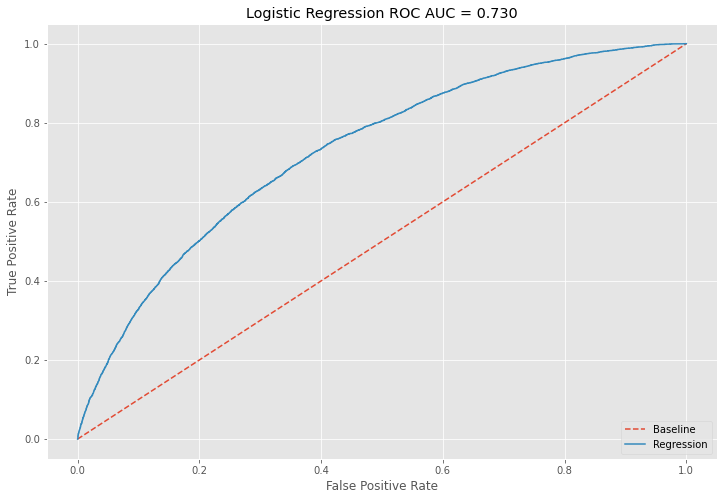

In [60]:
# Посмотрим ROC кривую

probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

# Визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### **Обучим модель на всем датасете**

In [61]:
model = LogisticRegression(penalty='l2', C=59.94842503189409, max_iter=800)
model.fit(X, Y)
probs = model.predict_proba(test)
probs = probs[:, 1]

#### **Cоздаём экземпляр таблицы с предсказаниями, чтобы выложить его на kaggle**

In [62]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission

,client_id,default
0,74835,0.234276
1,17527,0.868674
2,75683,0.363836
3,26883,0.420354
4,28862,0.139373
...,...,...
36344,83775,0.830410
36345,106254,0.103740
36346,81852,0.796193
36347,1971,0.713162
